In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS
from scipy.spatial import KDTree
from matplotlib import colors
import yaml

In [2]:
# Custom code to load .list files
import stuff

# New convolution implementation

## Configuration

In [3]:
print(open('/home/aalvarez/Work/Data/sim09/test_simplefit.config').read())

output-properties=PixelCentroid,SimpleModelFitting,SourceIDs
detection-image=/home/aalvarez/Work/Data/sim09/sim09_r_05.fits
psf-file=/home/aalvarez/Work/Data/sim09/sim09_r_05.psf
detection-image-saturation=59000
detection-image-gain=1
detect-minarea=10
partition-min-area=10
threads-nb=4
cellsize-value=32
partition-multithreshold=true
grouping-algorithm=SPLIT
checkimage-residual=/home/aalvarez/Work/Data/sim09/simple_residual.fits
checkimage-modelfitting=/home/aalvarez/Work/Data/sim09/simple_modelfitting.fits
checkimage-background=/home/aalvarez/Work/Data/sim09/simple_background.fits
checkimage-variance=/home/aalvarez/Work/Data/sim09/simple_variance.fits
checkimage-segmentation=/home/aalvarez/Work/Data/sim09/simple_segmentation.fits
checkimage-partition=/home/aalvarez/Work/Data/sim09/simple_partition.fits
checkimage-filtered=/home/aalvarez/Work/Data/sim09/simple_filtered.fits

output-file=/home/aalvarez/Work/Data/sim09/simple_output.fits



## Load simulation data

In [4]:
r_stars, r_galaxies = stuff.parse_stuff_list('/home/aalvarez/Work/Data/sim09/sim09_r.list')

## Display coadded image

In [5]:
coadd_img = fits.open('/home/aalvarez/Work/Data/sim09/sim09_r_05.fits')[0]

Text(0.5,1,'Coadded image')

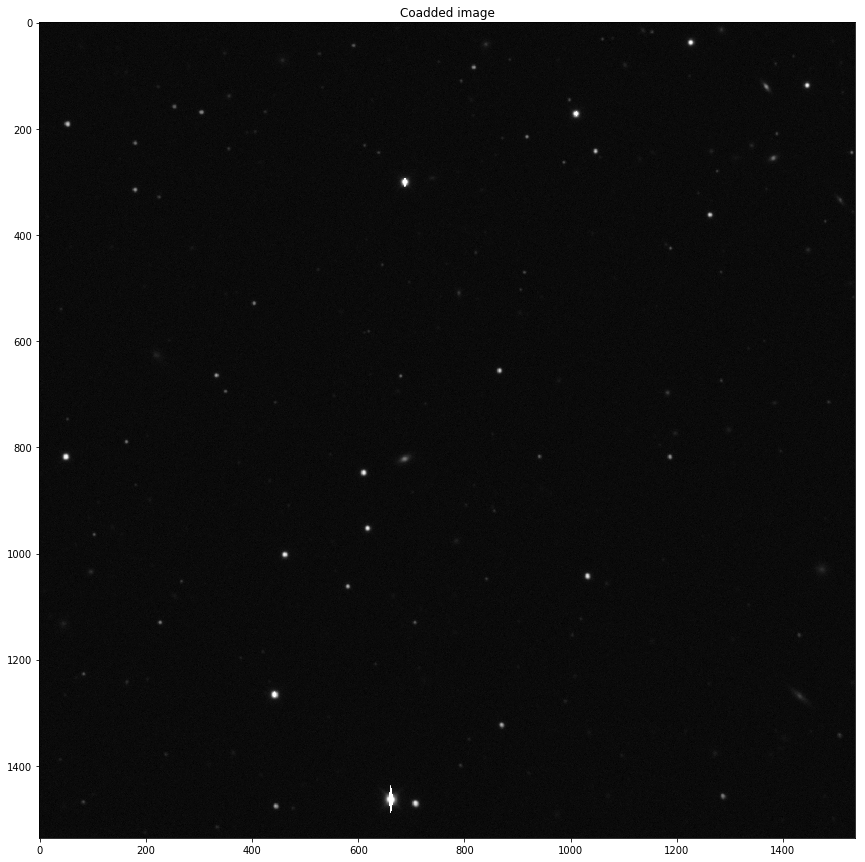

In [6]:
plt.figure(figsize=(15, 15))
plt.imshow(coadd_img.data, norm=colors.SymLogNorm(50), cmap=plt.get_cmap('Greys_r'))
plt.title('Coadded image')

### Build a KDTree with the source coordinates

In [7]:
stars_coords = np.stack([r_stars.ra, r_stars.dec]).T
galaxies_coords = np.stack([r_galaxies.ra, r_galaxies.dec]).T
all_coords = np.append(stars_coords, galaxies_coords, axis=0)
all_kdtree = KDTree(all_coords)
r_mags = np.append(r_stars.mag, r_galaxies.mag)

n_stars = len(r_stars)
n_galaxies = len(r_galaxies)

### Load the output catalog

In [8]:
output_catalog = Table.read('/home/aalvarez/Work/Data/sim09/simple_output.fits')

Compute magnitudes

In [9]:
# This comes from sim09_*_sky.conf
mag_zeropoint = 26.
exp_time = 300.

In [10]:
output_catalog['r_mag'] = mag_zeropoint - 2.5 * np.log10(output_catalog['smf_total_flux'] / exp_time)

### Compare results

In [11]:
def get_closest(catalog):
    distances = []
    index_c = []
    index_s = []
    for i, e in enumerate(catalog):
        d, s = all_kdtree.query([e['smf_alpha'], e['smf_delta']], 1)
        distances.append(d)
        index_c.append(i)
        index_s.append(s)
    return {
        'dist': np.array(distances),
        'catalog': np.array(index_c),
        'source': np.array(index_s),
    }

In [12]:
closest = get_closest(output_catalog)

In [13]:
print("Number of sources found:", len(closest['dist']))

Number of sources found: 279


In [14]:
def plot_stats(ax, data):
    ax.text(
        0.9, 0.9,
        '$\mu$: {:.3e}\n$\sigma$: {:.3e}\n$\%_{{50}}$: {:.3e}'.format(
            np.average(data),
            np.std(data),
            np.median(data),
        ),
        transform=ax.transAxes
    )

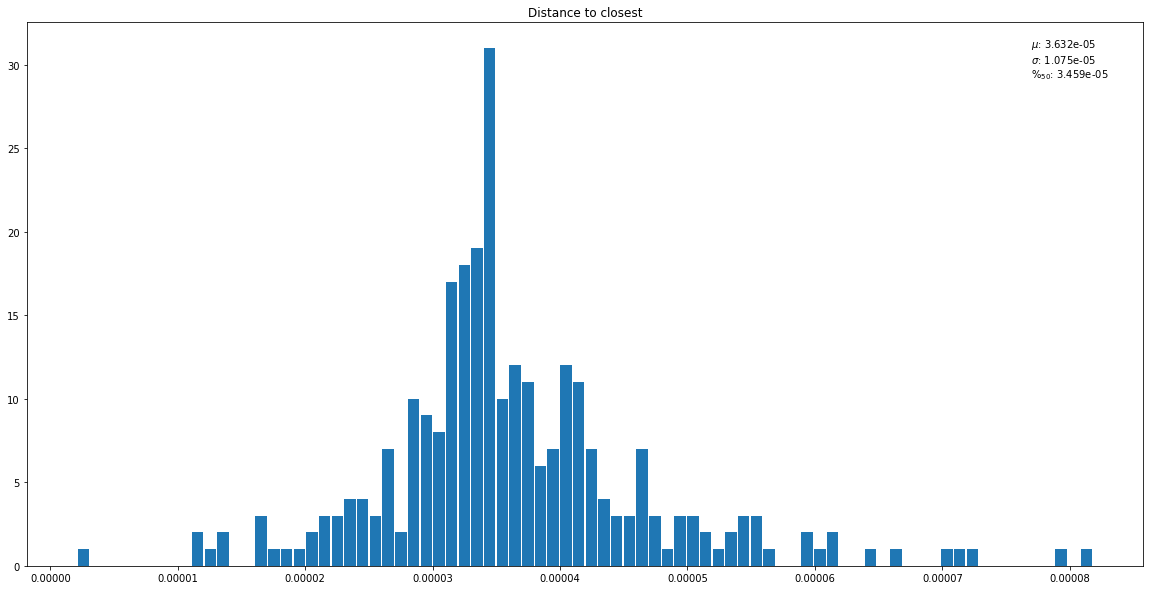

In [15]:
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1, 1, 1)
ax1.hist(closest['dist'], 80, rwidth=0.9)
plot_stats(ax1, closest['dist'])
_ = ax1.set_title('Distance to closest')

### Magnitudes

In [16]:
r_mag_diff = output_catalog[closest['catalog']]['r_mag'] - r_mags[closest['source']]
# Filter out outliers
outlier_filter = (r_mag_diff >= np.percentile(r_mag_diff, 5)) & (r_mag_diff <= np.percentile(r_mag_diff, 95))

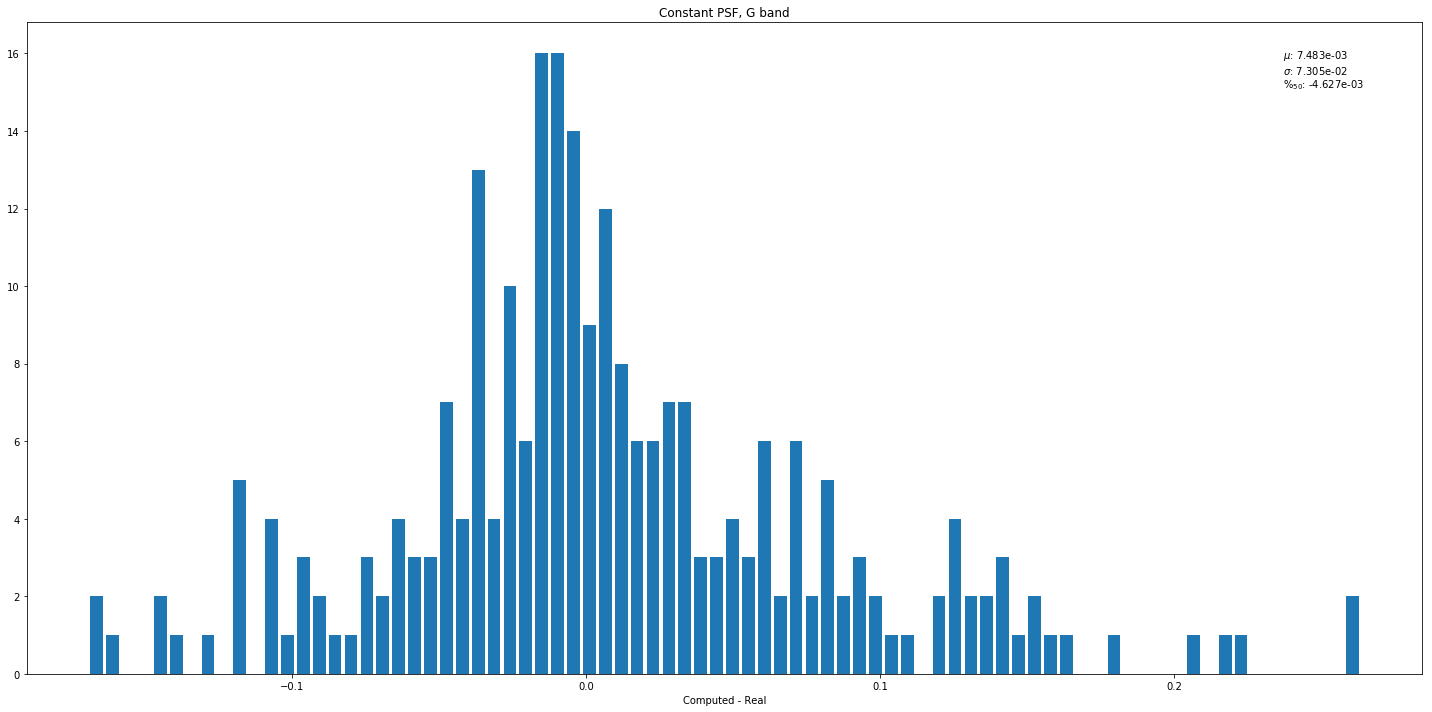

In [17]:
plt.figure(figsize=(20, 10))

ax1 = plt.subplot(1, 1, 1)
ax1.hist(r_mag_diff[outlier_filter], 80, rwidth=0.8)
ax1.set_xlabel('Computed - Real')
plot_stats(ax1, r_mag_diff[outlier_filter])
ax1.set_title('R band')

plt.tight_layout()

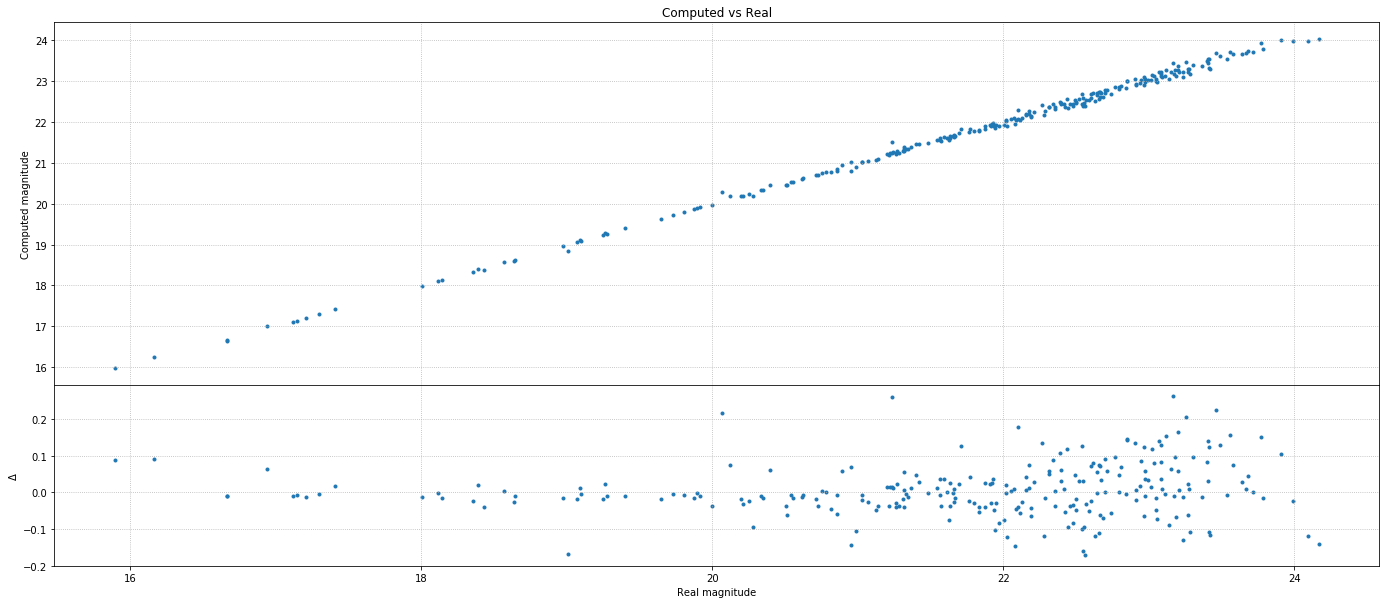

In [18]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(left=0.07, right=0.99, hspace=0.0, wspace=0.2)

ax1 = plt.subplot2grid((3, 1), (0, 0), 2)
ax1.scatter(
    r_mags[closest['source']][outlier_filter],
    output_catalog[closest['catalog']]['r_mag'][outlier_filter],
    marker='.'
)
ax1.set_ylabel('Computed magnitude')
ax1.set_xlabel('Real magnitude')
ax1.grid(True, linestyle=':')
ax1.set_title('Computed vs Real')

ax2 = plt.subplot2grid((3, 1), (2, 0), 1)
ax2.scatter(
    r_mags[closest['source']][outlier_filter],
    (output_catalog[closest['catalog']]['r_mag'] - r_mags[closest['source']])[outlier_filter],
    marker='.'
)
ax2.set_ylabel('$\Delta$')
ax2.set_xlabel('Real magnitude')
ax2.grid(True, linestyle=':')


_ = 0

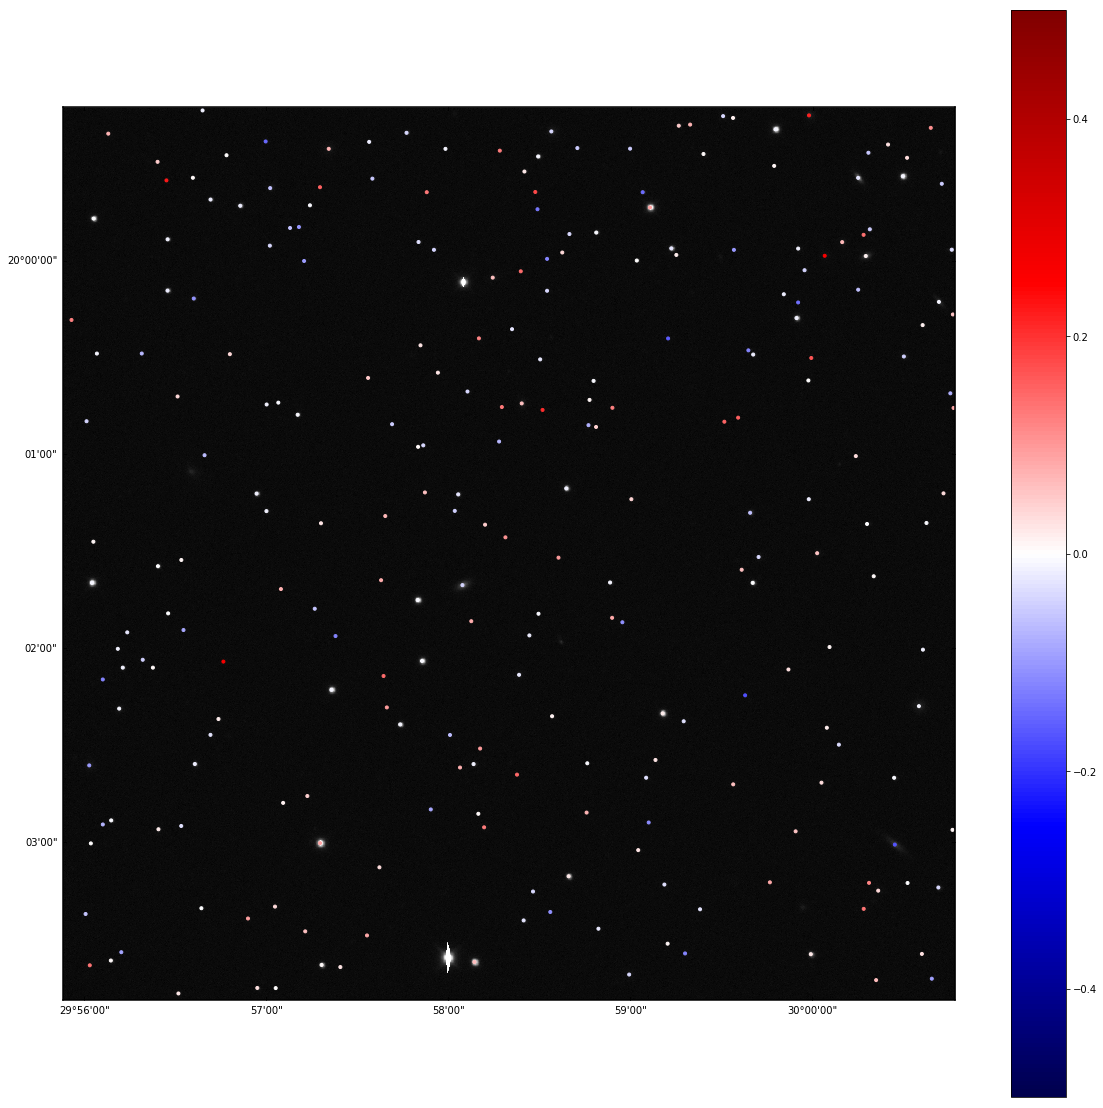

In [19]:
weights = fits.open('/home/aalvarez/Work/Data/sim09/sim09_r_05.fits')[0]

wcs = WCS(coadd_img.header)
max_abs_diff = np.max(np.abs(r_mag_diff[outlier_filter]))

pixel_coords = wcs.all_world2pix(
    output_catalog[closest['catalog']]['smf_alpha'][outlier_filter],
    output_catalog[closest['catalog']]['smf_delta'][outlier_filter],
    0
)

plt.figure(figsize=(20, 20))
ax1 = plt.subplot(1, 1, 1, projection=wcs)
ax1.imshow(weights.data, norm=colors.SymLogNorm(50), cmap=plt.get_cmap('Greys_r'))
sc = ax1.scatter(
    pixel_coords[0],
    pixel_coords[1],
    c=r_mag_diff[outlier_filter],
    marker='.',
    cmap = plt.get_cmap('seismic'),
    norm = colors.Normalize(vmin=-0.5, vmax=0.5)
)
plt.colorbar(sc)